In [ ]:
!pip install gudhi
!pip install hdbscan
!pip install genieclust
from scipy.spatial import distance
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
from numpy.linalg import matrix_rank
import numpy as np
import gudhi as gd
import matplotlib
import scipy.spatial as spatial
import bisect
import matplotlib
from scipy.cluster import hierarchy
from urllib.request import urlopen
from io import BytesIO
from gudhi import AlphaComplex
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import ward, fcluster
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
import time
from scipy.spatial import KDTree
from sklearn.datasets import make_blobs
from sklearn.metrics import calinski_harabasz_score
import pandas as pd
import random
from sklearn.cluster import DBSCAN
import hdbscan
from gudhi.clustering.tomato import Tomato
import genieclust
from scipy.spatial.distance import pdist
from sklearn import metrics
from sklearn.mixture import GaussianMixture

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 33.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree, NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import PolynomialFeatures
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

class FiltrationBuilder:
    def __init__(self, data):
        self.data = data

    def get_filtration(self, dist):
        filtration = []
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                if i > j:
                    continue
                elif i == j:
                    filtration.append(([i], dist[i][j]))
                else:
                    filtration.append(([i, j], dist[i][j]))
        filtration = sorted(filtration, key=lambda x: (x[1], x[0]))
        return self.transform_filtration(filtration)

    def transform_filtration(self, filtration):
        new_filtration = []
        new_filtration.append(filtration[0])
        if filtration[1][1] == filtration[0][1]:
            new_filtration.append((filtration[1][0], filtration[1][1] + 1e-15))
        else:
            new_filtration.append(filtration[1])
        for i in range(2, len(filtration)):
            if filtration[i][1] == filtration[i-1][1] and filtration[i][1] == filtration[i-2][1]:
                new_filtration.append((filtration[i][0], new_filtration[-1][1] + 1e-15))
            elif filtration[i][1] == filtration[i-1][1]:
                new_filtration.append((filtration[i][0], filtration[i-1][1] + 1e-15))
            else:
                new_filtration.append(filtration[i])
        return new_filtration

    def get_filtration_from_scipy_dist(self, dist_type):
        dist = cdist(self.data, self.data, dist_type)
        return self.get_filtration(dist)

    def get_filtration_from_density(self, kernel_type, bandwidth):
        kde = KernelDensity(kernel=kernel_type, bandwidth=bandwidth).fit(self.data)
        point_density = np.exp(kde.score_samples(self.data)).tolist()
        maximum = np.max(np.exp(kde.score_samples(self.data)))
        second_maximum = np.sort(np.exp(kde.score_samples(self.data)))[-2]
        dist = [[0 for _ in range(len(self.data))] for _ in range(len(self.data))]
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                if i < j:
                    dist[i][j] = abs(point_density[i] - point_density[j])
                    dist[j][i] = dist[i][j]
        return self.get_filtration(dist)

    def get_not_normalized_filtration_from_density(self, r):
        tree = KDTree(self.data)
        densities = tree.query_ball_point(self.data, r)
        point_density = np.array([len(neighbors) for neighbors in densities])
        maximum = max(point_density)
        second_maximum = sorted(point_density)[-2]
        dist = [[0 for _ in range(len(self.data))] for _ in range(len(self.data))]
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                if i < j:
                    dist[i][j] = abs(point_density[i] - point_density[j])
                    dist[j][i] = dist[i][j]
        return self.get_filtration(dist)

    def get_filtration_from_curvature(self):
        x = np.array(self.data)[:, 0]
        y = np.array(self.data)[:, 1]
        dx = np.gradient(x)
        dy = np.gradient(y)
        d2x = np.gradient(dx)
        d2y = np.gradient(dy)
        curvatures = np.abs(d2x * dy - dx * d2y) / (dx**2 + dy**2)**1.5
        dist = [[0 for _ in range(len(self.data))] for _ in range(len(self.data))]
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                if i < j:
                    dist[i][j] = curvatures[i] + curvatures[j]
                    dist[j][i] = dist[i][j]
        return self.get_filtration(dist)

    def get_filtration_from_knn(self, k):
        nbrs = NearestNeighbors(n_neighbors=k).fit(self.data)
        distances, _ = nbrs.kneighbors(self.data)
        knn_distances = distances[:, -1]
        maximum = np.max(knn_distances)
        second_maximum = np.sort(knn_distances)[-2] if len(knn_distances) >= 2 else maximum
        dist = [[0.0 for _ in range(len(self.data))] for _ in range(len(self.data))]
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                if i < j:
                    val = abs(knn_distances[i] - knn_distances[j])
                    dist[i][j] = val
                    dist[j][i] = val
        return self.get_filtration(dist)

    def get_filtration_from_christoffel(self, degree):
        N = len(self.data)
        poly = PolynomialFeatures(degree=degree, include_bias=True)
        V = poly.fit_transform(self.data)
        s = V.shape[1]
        res = V[0].reshape(-1, 1) @ V[0].reshape(1, -1)
        for i in range(1, len(V)):
            Vi = V[i].reshape(-1, 1)
            res += Vi @ Vi.T
        M_d = (1.0 / N) * res
        M_d_inv = np.linalg.pinv(M_d)
        Q = np.sum(V * (np.dot(V, M_d_inv)), axis=1)
        Lambda = 1.0 / Q
        christoffel_density = s * Lambda
        max_density = np.max(christoffel_density)
        second_max = np.sort(christoffel_density)[-2] if N >= 2 else max_density
        dist = [[0 for _ in range(len(self.data))] for _ in range(len(self.data))]
        for i in range(len(self.data)):
            for j in range(i+1, len(self.data)):
                val = abs(christoffel_density[i] - christoffel_density[j])
                dist[i][j] = val
                dist[j][i] = val
        return self.get_filtration(dist)

    def get_filtration_from_intrinsic_dim(self, k_neighbors=10, var_threshold=0.95):
        nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1).fit(self.data)
        _, indices = nbrs.kneighbors(self.data)
        intrinsic_dims = []
        for idx_list in indices:
            X_local = self.data[idx_list[1:]]
            pca = PCA().fit(X_local)
            cum_var = np.cumsum(pca.explained_variance_ratio_)
            intrinsic_dims.append(np.searchsorted(cum_var, var_threshold) + 1)
        intrinsic_dims = np.array(intrinsic_dims)
        max_dim = np.max(intrinsic_dims)
        second_max = np.sort(intrinsic_dims)[-2] if len(intrinsic_dims) >= 2 else max_dim
        n = len(self.data)
        dist = [[0.0 for _ in range(n)] for _ in range(n)]
        nbrs = NearestNeighbors(n_neighbors=2 * k_neighbors).fit(self.data)
        _, indices = nbrs.kneighbors(self.data)
        for i in range(n):
            for j in range(i + 1, n):
                dim_diff = abs(intrinsic_dims[i] - intrinsic_dims[j])
                val = 10 * dim_diff
                if dim_diff == 0:
                    if j not in indices[i][1:]:
                        val += 8 
                val += np.random.random() * 2
                dist[i][j] = val
                dist[j][i] = val
        for i in range(n):
            dist[i][i] = 0
        return self.get_filtration(dist)

class BifiltrationProcessor:
    def __init__(self, filtration1, filtration2):
        self.filtration1 = filtration1
        self.filtration2 = filtration2

    def critical_points(self):
        filtration1_dict, filtration2_dict = dict(), dict()
        filtration1_dict_rev, filtration2_dict_rev = dict(), dict()
        for i in range(len(self.filtration1)):
            filtration1_dict[tuple(self.filtration1[i][0])] = (self.filtration1[i][1], i)
            filtration1_dict_rev[i] = self.filtration1[i][0]
        for i in range(len(self.filtration2)):
            filtration2_dict[tuple(self.filtration2[i][0])] = (self.filtration2[i][1], i)
            filtration2_dict_rev[i] = self.filtration2[i][0]

        grid = [[-1 for i in range(len(self.filtration2))] for j in range(len(self.filtration1))]
        for item in filtration1_dict.items():
            grid[item[1][1]][filtration2_dict[item[0]][1]] = 0

        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if (i != 0) and (j != 0) and grid[i - 1][j] == 0 and grid[i][j - 1] == 0:
                    grid[i][j] = 1
        return grid, filtration1_dict_rev, filtration2_dict_rev, filtration1_dict, filtration2_dict

    def get_slice(self, f, f_invers):
        grid, filtration1_dict_rev, filtration2_dict_rev, filtration1_dict, filtration2_dict = self.critical_points()

        prepared_filtration = []
        for x_grid in range(len(self.filtration1)):
            for y_grid in range(len(self.filtration2)):
                x_grid_val = self.filtration1[x_grid][1]
                y_grid_val = self.filtration2[y_grid][1]
                y_line = f(x_grid_val)
                x_line = f_invers(y_grid_val)
                if y_line <= y_grid_val: 
                    if grid[x_grid][y_grid] == 0:
                        prepared_filtration.append((filtration1_dict_rev[x_grid], y_grid_val + x_line, x_line - x_grid_val))
                    elif grid[x_grid][y_grid] == 1:
                        prepared_filtration.append((filtration1_dict_rev[x_grid - 1], y_grid_val + x_line, x_line - x_grid_val))
                else: 
                    if grid[x_grid][y_grid] == 0:
                        prepared_filtration.append((filtration2_dict_rev[y_grid], y_line + x_grid_val, y_line - y_grid_val))
                    elif grid[x_grid][y_grid] == 1:
                        prepared_filtration.append((filtration2_dict_rev[y_grid - 1], y_line + x_grid_val, y_line - y_grid_val))

        prepared_filtration = sorted(prepared_filtration, key= lambda x: (x[1], x[2]))
        filtration = []
        filtration.append((prepared_filtration[0][0], prepared_filtration[0][1]))
        for i in range(1, len(prepared_filtration)):
            if prepared_filtration[i][1] != prepared_filtration[i - 1][1]:
                filtration.append((prepared_filtration[i][0], prepared_filtration[i][1]))
        return filtration

    def get_slice_optimized(self, f, f_inverse):
        f1_dict = {tuple(simplex): (value, idx) for idx, (simplex, value) in enumerate(self.filtration1)}
        f2_dict = {tuple(simplex): (value, idx) for idx, (simplex, value) in enumerate(self.filtration2)}

        prepared_filtration = []

        for simplex, (value1, idx1) in f1_dict.items():
            if simplex in f2_dict:
                value2, idx2 = f2_dict[simplex]
                x_line = f_inverse(value2)
                y_line = f(value1)
                if y_line <= value2:
                    projected_value = value2 + x_line
                    dist = x_line - value1
                else:
                    projected_value = y_line + value1
                    dist = y_line - value2
                prepared_filtration.append((simplex, projected_value, dist))

        prepared_filtration.sort(key=lambda x: (x[1], x[2]))
        filtration = []
        for i in range(len(prepared_filtration)):
            if i == 0 or prepared_filtration[i][1] != prepared_filtration[i-1][1]:
                filtration.append((prepared_filtration[i][0], prepared_filtration[i][1]))

        return filtration


    def get_path(self):
        set_list1 = []
        set_list2 = []
        curr_set = set()
        for simpl, val in self.filtration1:
            curr_set.add(tuple(simpl))
            set_list1.append(curr_set.copy())

        curr_set = set()
        for simpl, val in self.filtration2:
            curr_set.add(tuple(simpl))
            set_list2.append(curr_set.copy())

        prepared_filtration = []
        up = True
        x_grid = 0
        y_grid = 0
        curr_set = set()
        while x_grid < len(self.filtration1):
            if (x_grid == len(self.filtration1)) or (y_grid == len(self.filtration2)):
                break
            while y_grid < len(self.filtration2):
                if (x_grid == len(self.filtration1)) or (y_grid == len(self.filtration2)):
                    break
                inter = set_list1[x_grid].intersection(set_list2[y_grid])
                simplex = inter.difference(curr_set)
                if len(simplex) != 0:
                    prepared_filtration.append((list(list(simplex)[0]), self.filtration1[x_grid][1] + self.filtration2[y_grid][1]))
                curr_set = inter
                if up == True:
                    x_grid += 1
                    up = False
                else:
                    y_grid += 1
                    up = True
        if up == False:
            inter = set_list1[-1].intersection(set_list2[-1])
            simplex = inter.difference(curr_set)
            if len(simplex) != 0:
                prepared_filtration.append((list(list(simplex)[0]), self.filtration1[-1][1] + self.filtration2[-1][1]))
        return prepared_filtration

    def get_raw_critical_points(self):
        f1_dict = {tuple(simplex): val for simplex, val in self.filtration1}
        f2_dict = {tuple(simplex): val for simplex, val in self.filtration2}

        critical_points = []
        for simplex in f1_dict:
            if simplex in f2_dict:
                critical_points.append((
                    f1_dict[simplex],
                    f2_dict[simplex],
                    list(simplex)
                ))

        return critical_points

    def plot_critical_points_2d(self, title="Critical Points",
                               color='blue', marker_size=50,
                               grid=True, show_labels=False,
                               plot_function=None,
                               func_x_range=None,
                               func_style={'color': 'red', 'linestyle': '--', 'label': 'Function'}):
        points = self.get_raw_critical_points()
        x_points = [p[0] for p in points]
        y_points = [p[1] for p in points]
        labels = [str(p[2]) for p in points]

        plt.figure(figsize=(10, 6))

        plt.scatter(x_points, y_points,
                   s=marker_size,
                   c=color,
                   edgecolors='black',
                   linewidths=0.5,
                   label='Critical Points')

        if plot_function is not None:
            if func_x_range is None:
                x_min, x_max = min(x_points), max(x_points)
                x_vals = np.linspace(x_min, x_max, 100)
            else:
                x_vals = np.linspace(*func_x_range)

            y_vals = plot_function(x_vals)
            plt.plot(x_vals, y_vals, **func_style)

        if show_labels:
            for xi, yi, label in zip(x_points, y_points, labels):
                plt.text(xi, yi, label,
                        fontsize=8,
                        ha='center',
                        va='bottom',
                        bbox=dict(boxstyle="round,pad=0.2",
                                facecolor='white',
                                edgecolor='none',
                                alpha=0.8))

        plt.title(title, fontsize=14)
        plt.xlabel("Filtration 1 Value", fontsize=12)
        plt.ylabel("Filtration 2 Value", fontsize=12)
        plt.legend()

        if grid:
            plt.grid(True, linestyle=':', color='grey', alpha=0.7)

        plt.tight_layout()
        plt.show()

    def plot_bifiltration_grid(self, filtration1, filtration2):
          grid, f1_rev, f2_rev, f1_dict, f2_dict = self.critical_points(filtration1, filtration2)

          plt.figure(figsize=(10, 10))

          for i in range(len(grid)):
              for j in range(len(grid[0])):
                  if grid[i][j] == 0:
                      color = 'red'
                      marker = 'o'
                      size = 50
                  elif grid[i][j] == 1:
                      color = 'blue'
                      marker = 's'
                      size = 30
                  else:
                      continue

                  plt.scatter(i, j, c=color, marker=marker, s=size, edgecolors='black')

          plt.xticks(range(len(filtration1)),
                    labels=[f"{filtration1[i][0]}" for i in range(len(filtration1))],
                    rotation=45)
          plt.yticks(range(len(filtration2)),
                    labels=[f"{filtration2[i][0]}" for i in range(len(filtration2))])

          plt.xlabel("Filtration 1 Index")
          plt.ylabel("Filtration 2 Index")
          plt.title("Bifiltration Critical Points Grid")

          plt.grid(True, linestyle='--', alpha=0.7)
          plt.gca().set_axisbelow(True)

          plt.scatter([], [], c='red', marker='o', s=50, label='Primary Critical Points')
          plt.scatter([], [], c='blue', marker='s', s=30, label='Secondary Critical Points')
          plt.legend()

          plt.tight_layout()
          plt.show()

class ClusteringUtils:
    @staticmethod
    def format_filtration(filtration):
        filtration_upd = []
        for i in filtration:
            if len(i[0]) == 2:
                filtration_upd.append((i[0][0], i[0][1], i[1]))
        return filtration_upd

    @staticmethod
    def get_linkage_matrix(filtration, K):
        filtration = ClusteringUtils.format_filtration(filtration)
        clusters = {i: [i] for i in range(K)}
        ind = K
        linkage_matrix = []

        for el in filtration:
            clust1 = next(clust for clust, items in clusters.items() if el[0] in items)
            clust2 = next(clust for clust, items in clusters.items() if el[1] in items)

            if clust1 != clust2:
                cluster_upd = clusters[clust1] + clusters[clust2]
                linkage_matrix.append([clust1, clust2, el[2], len(cluster_upd)])
                clusters[ind] = cluster_upd
                del clusters[clust1]
                del clusters[clust2]
                ind += 1
        return np.array(linkage_matrix)

    @staticmethod
    def plot_merge_tree(linkage_matrix, threshold):
        plt.figure(figsize=(10, 5))
        dendrogram(linkage_matrix)
        plt.title('Dendrogram')
        plt.xlabel('Data points')
        plt.ylabel('Height')
        plt.axhline(y=threshold, color='r', linestyle='-')
        plt.show()
        return

    @staticmethod
    def merge_clusters(data, start_clusters, linkage_matrix, min_size, distance_matrix):
        sizes = {cluster: np.sum((start_clusters == cluster)) for cluster in np.unique(start_clusters)}
        new_clusters = {cluster for cluster, size in sizes.items() if size < min_size}
        while new_clusters:
            c = new_clusters.pop()
            points = np.where(start_clusters == c)[0]
            min_distance = np.inf
            closest_cluster = None
            for cluster in sizes:
                if cluster != c and sizes[cluster] >= min_size:
                    for point in points:
                        distances = distance_matrix[point, start_clusters == cluster]
                        if np.min(distances) < min_distance:
                            min_distance = np.min(distances)
                            closest_cluster = cluster
            if closest_cluster is not None:
                start_clusters[points] = closest_cluster
                sizes[closest_cluster] += len(points)
            else:
                continue
            sizes[c] = 0
        return start_clusters
    
    @staticmethod
    def get_merge_history_with_heights(filtration, K, res=None):
        set_vertex = set()
        filtration_upd = ClusteringUtils.format_filtration(filtration)
        
        clusters = {i: [i] for i in range(K)}
        merge_history = {}
        creation_heights = {i: 0.0 for i in range(K)}
        current_max_id = K  
        cluster_sizes = {i: 1 for i in range(K)}
        
        for el in filtration_upd:
            clust1 = next((c for c, items in clusters.items() if el[0] in items), None)
            clust2 = next((c for c, items in clusters.items() if el[1] in items), None)
            
            if clust1 is not None and clust2 is not None and clust1 != clust2:
                new_cluster = current_max_id
                merge_distance = el[2]
                
                merge_history[clust1] = new_cluster
                merge_history[clust2] = new_cluster
                creation_heights[new_cluster] = merge_distance
                cluster_sizes[new_cluster] = cluster_sizes[clust1] + cluster_sizes[clust2]
                
                clusters[new_cluster] = clusters[clust1] + clusters[clust2]
                if res is not None and clust1 in res:
                  set_vertex.update(clusters[clust1])
                if res is not None and clust2 in res:
                  set_vertex.update(clusters[clust2])
                del clusters[clust1]
                del clusters[clust2]
                
                current_max_id += 1 
                
        return merge_history, creation_heights, current_max_id - 1, cluster_sizes, set_vertex

    @staticmethod
    def find_persistent_noise(filtration, K):
      merge_history, creation_heights, max_ind, cluster_sizes, _ = ClusteringUtils.get_merge_history_with_heights(filtration, K)
      heights = np.zeros(max_ind)
      for i in range(max_ind):
        if cluster_sizes[i] < 7:
          heights[i] = creation_heights[merge_history[i]] - creation_heights[i]
      res = []
      for i in range(len(heights)):
        if heights[i] >= 0.25 * creation_heights[max_ind - 1]:
          res.append(i)
      _, _, _, _, noise = ClusteringUtils.get_merge_history_with_heights(filtration, K, res)
      return noise

In [4]:
class ClusterVisualizer:
    @staticmethod
    def plot_3d_clusters(data, labels, cluster_colors=None):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        if cluster_colors is not None:
            color_array = [cluster_colors[label - 1] for label in labels]
        else:
            color_array = labels

        sc = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color_array, s=40)
        ax.set_title('3D Cluster Visualization')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()

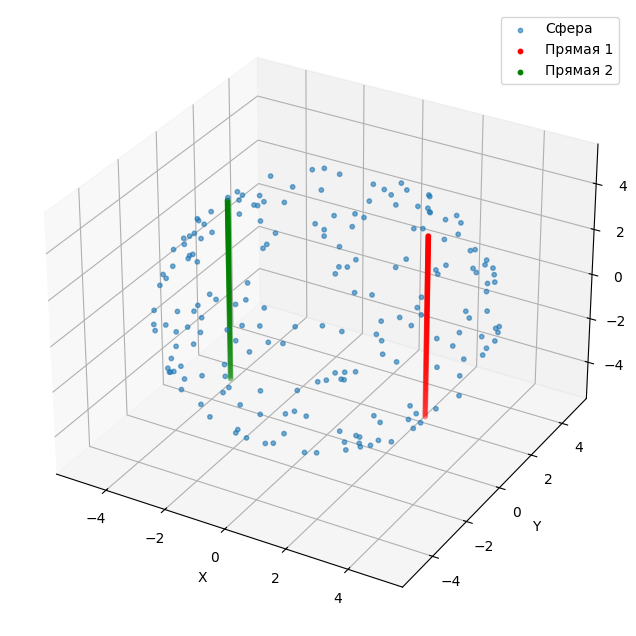

Дендрограмма фильтрации по расстоянию


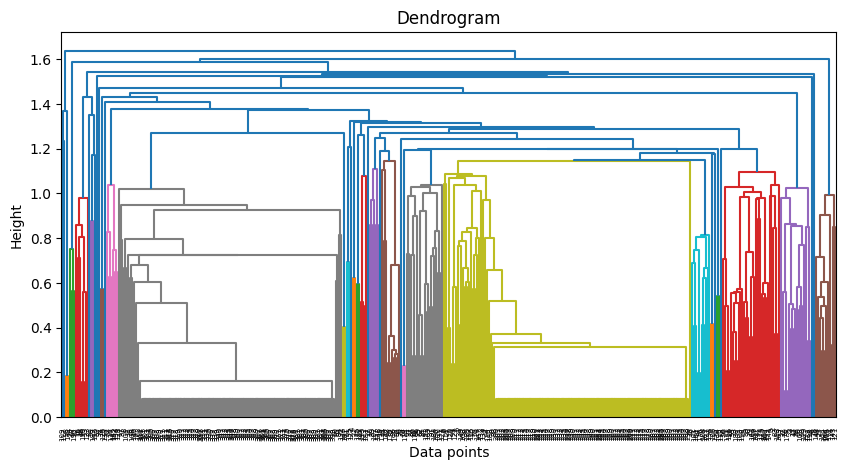

Дендрограмма фильтрации по внутренней размерности


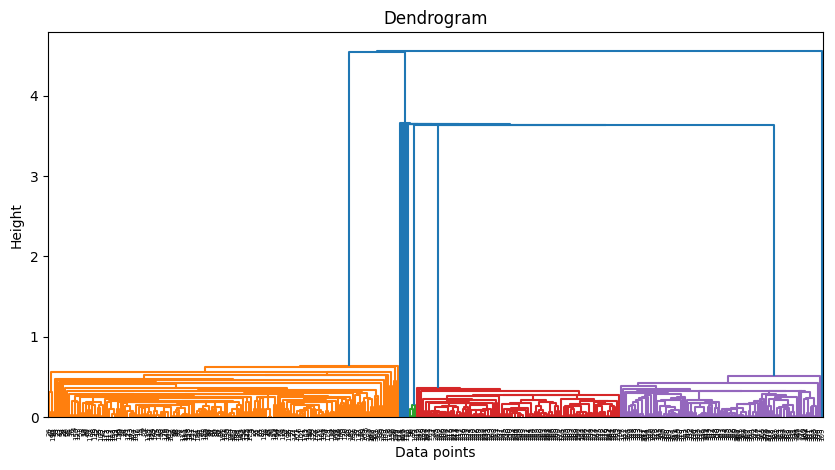

Общая дендрограмма


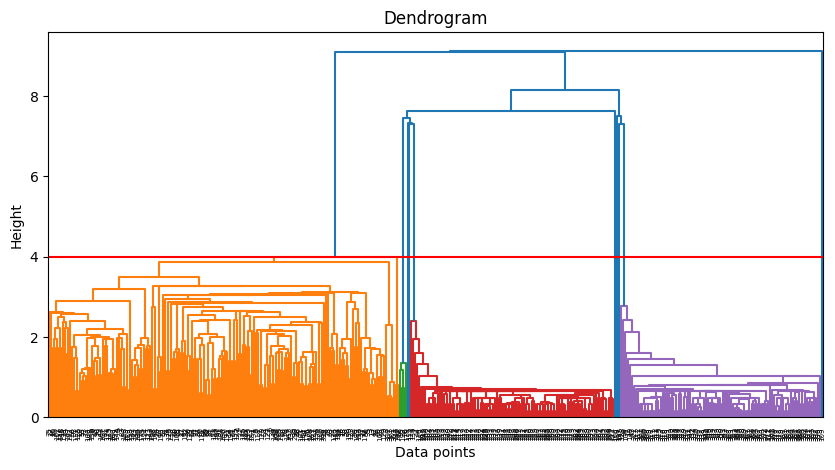

In [7]:
radius = 5
center = (0, 0, 0)
num_sphere_points = 200

theta = np.random.uniform(0, 2 * np.pi, num_sphere_points)
phi = np.arccos(np.random.uniform(-1, 1, num_sphere_points))
x_sphere = radius * np.sin(phi) * np.cos(theta)
y_sphere = radius * np.sin(phi) * np.sin(theta)
z_sphere = radius * np.cos(phi)

num_line_points = 100

a1, b1 = 3, 0.5
distance1 = np.sqrt(a1**2 + b1**2)
max_z1 = np.sqrt(radius**2 - distance1**2)
z_line1 = np.linspace(-max_z1, max_z1, num_line_points)
x_line1 = np.full(num_line_points, a1)
y_line1 = np.full(num_line_points, b1)

a2, b2 = -3, -0.5
distance2 = np.sqrt(a2**2 + b2**2)
max_z2 = np.sqrt(radius**2 - distance2**2)
z_line2 = np.linspace(-max_z2, max_z2, num_line_points)
x_line2 = np.full(num_line_points, a2)
y_line2 = np.full(num_line_points, b2)

x = np.concatenate([x_sphere, x_line1, x_line2])
y = np.concatenate([y_sphere, y_line1, y_line2])
z = np.concatenate([z_sphere, z_line1, z_line2])


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_sphere, y_sphere, z_sphere, s=10, alpha=0.6, label='Сфера')
ax.scatter(x_line1, y_line1, z_line1, s=10, color='red', label='Прямая 1')
ax.scatter(x_line2, y_line2, z_line2, s=10, color='green', label='Прямая 2')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

dataset = np.column_stack((x, y, z))
data = dataset
K = len(data)

fb = FiltrationBuilder(data)
filtration1 = fb.get_filtration_from_scipy_dist('euclidean')
filtration2 = fb.get_filtration_from_intrinsic_dim(k_neighbors=5)

filtration2 = [list(item) for item in filtration2]
max1 = max(item[1] for item in filtration1)
max2 = max(item[1] for item in filtration2)
filtration2 = [tuple([item[0], (item[1]/max2)*max1]) for item in filtration2]

bf_processor = BifiltrationProcessor(filtration1, filtration2)
filtration = bf_processor.get_slice_optimized(lambda x:  x, lambda y: y )

print("Дендрограмма фильтрации по расстоянию")
linkage_matrix1 = ClusteringUtils.get_linkage_matrix(filtration1, K)
ClusteringUtils.plot_merge_tree(linkage_matrix1, threshold=120)
print("Дендрограмма фильтрации по внутренней размерности")
linkage_matrix2 = ClusteringUtils.get_linkage_matrix(filtration2, K)
ClusteringUtils.plot_merge_tree(linkage_matrix2, threshold=120)
print("Общая дендрограмма")
linkage_matrix = ClusteringUtils.get_linkage_matrix(filtration, K)
n_samples = linkage_matrix.shape[0] + 1  # Количество исходных точек
n_clusters = 10
threshold_idx = n_samples - n_clusters - 1
ClusteringUtils.plot_merge_tree(linkage_matrix, threshold=linkage_matrix[threshold_idx, 2])

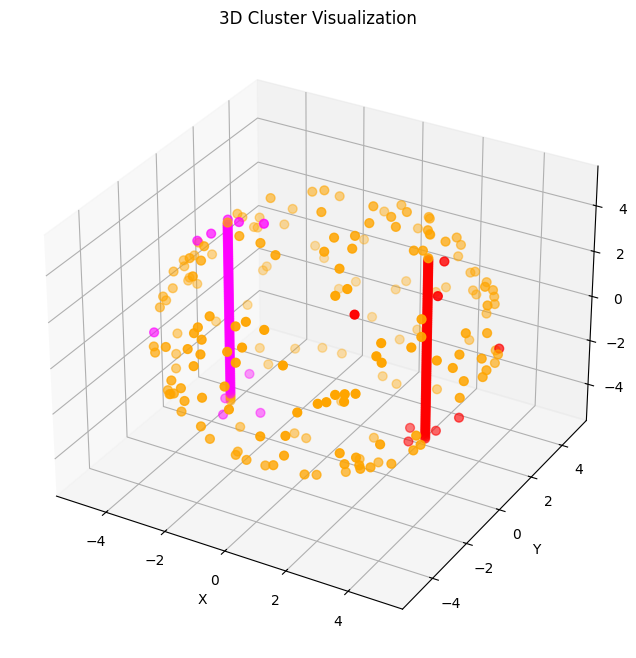

In [8]:
labels = fcluster(linkage_matrix, t=7, criterion='maxclust')
ClusteringUtils.merge_clusters(data, labels, linkage_matrix, 10, squareform(pdist(data)))
custom_colors = [
    '#FFA500',  # Красный для кластера 1
    '#A52A2A',  # Зеленый для кластера 2
    '#FF0000',  # Синий для кластера 3
    '#A52A2A',  # Желтый для кластера 4
    '#FF00FF',  # Пурпурный для кластера 5
    '#800080',  # Бирюзовый для кластера 6
    '#A52A2A',  # Оранжевый для кластера 7
    '#800080',  # Фиолетовый для кластера 8
    '#A52A2A',  # Коричневый для кластера 9
    '#808080'   # Серый для кластера 10
]

ClusterVisualizer.plot_3d_clusters(data, labels, cluster_colors=custom_colors)

Только по расстоянию


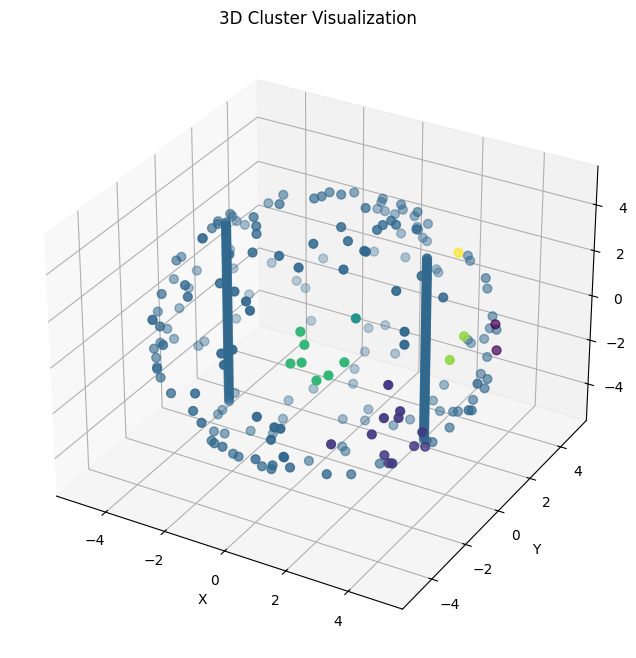

Только по внутренней размерности


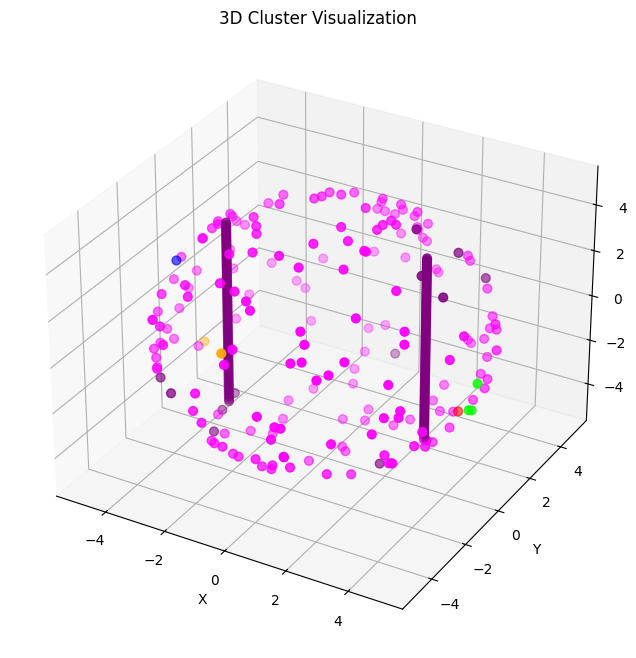

In [ ]:
print("Только по расстоянию")
labels = fcluster(linkage_matrix1, t=7, criterion='maxclust')
ClusterVisualizer.plot_3d_clusters(data, labels)
print("Только по внутренней размерности")
labels = fcluster(linkage_matrix2, t=7, criterion='maxclust')
custom_colors = [
    '#FFA500',  # Красный для кластера 1
    '#00FF00',  # Зеленый для кластера 2
    '#FF0000',  # Синий для кластера 3
    '#0000FF',  # Желтый для кластера 4
    '#FF00FF',  # Пурпурный для кластера 5
    '#800080',  # Бирюзовый для кластера 6
    '#FFA500',  # Оранжевый для кластера 7
    '#800080',  # Фиолетовый для кластера 8
    '#A52A2A',  # Коричневый для кластера 9
    '#808080'   # Серый для кластера 10
]

ClusterVisualizer.plot_3d_clusters(data, labels, cluster_colors=custom_colors)

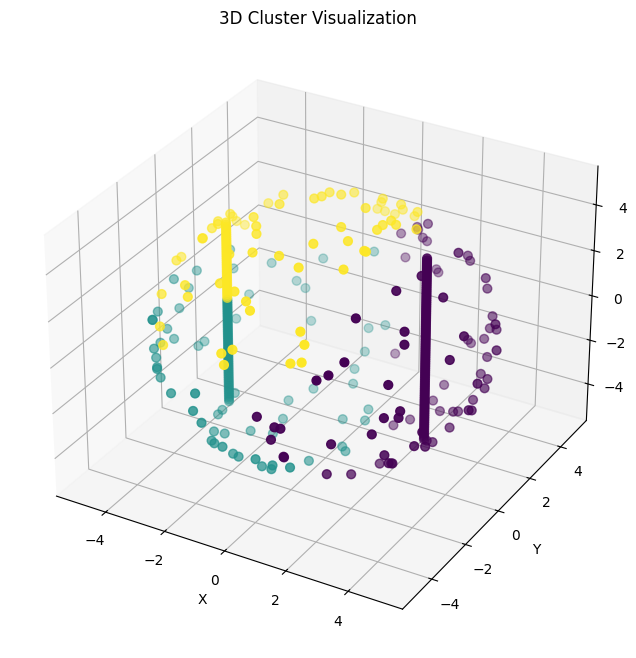

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(data)
ClusterVisualizer.plot_3d_clusters(data, kmeans.labels_)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


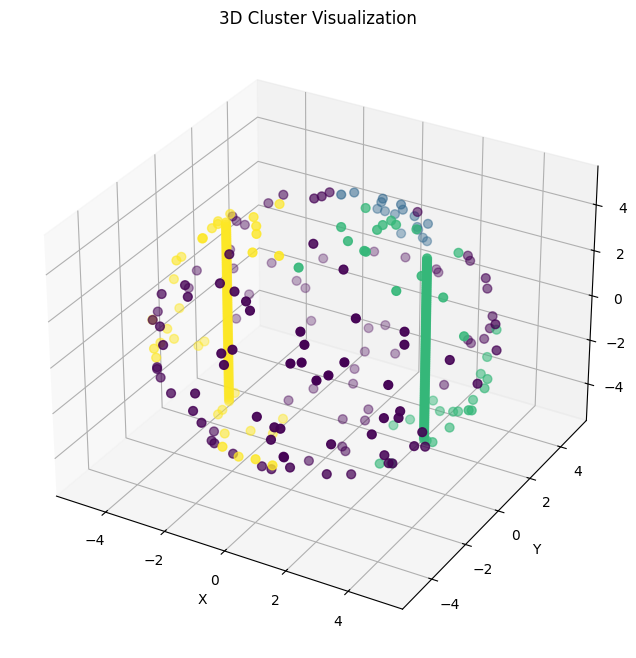

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
clusterer.fit(data)
ClusterVisualizer.plot_3d_clusters(data, clusterer.labels_)

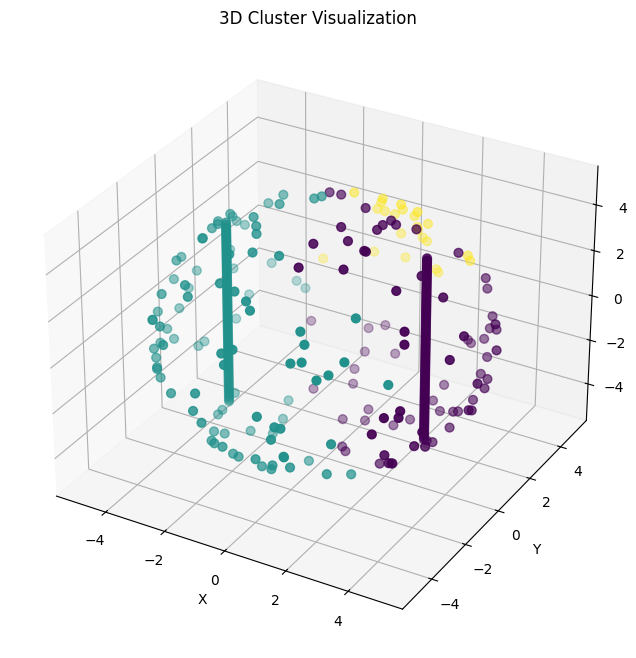

In [ ]:
clusterer = Tomato()
clusterer.fit(data)

clusterer.n_clusters_= 3
ClusterVisualizer.plot_3d_clusters(data, clusterer.labels_)

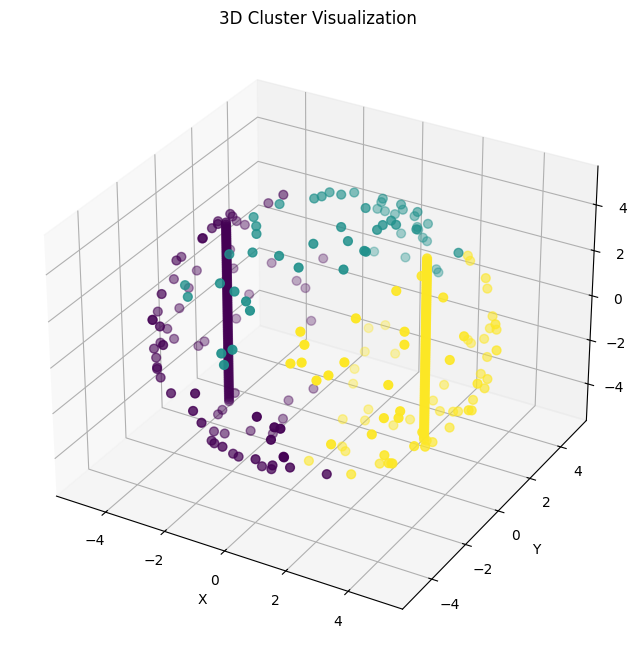

In [ ]:
clusterer = genieclust.Genie(n_clusters=3, gini_threshold=0.2)
labels = clusterer.fit_predict(data)
ClusterVisualizer.plot_3d_clusters(data, clusterer.labels_)